## Python import

In [1]:
!pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in c:\users\308_2\.conda\envs\minji\lib\site-packages (1.0.1)


In [2]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import cv2 #pip install opencv-python
from cv2 import cv2
from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

import efficientnet.tfkeras as efn 
from efficientnet.tfkeras import EfficientNetB4

In [3]:
print(tf.__version__,keras.__version__)

2.2.0 2.4.3


## Load Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

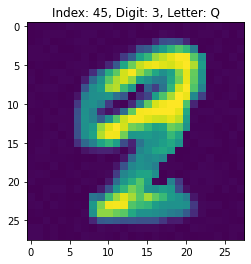

In [5]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## efficientnet에 넣어지게 수정

## Train model

In [6]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [7]:
x_train.shape

(2048, 28, 28, 1)

In [8]:
x_train_3=x_train.repeat(3,-1)

In [9]:
x_train_3.shape

(2048, 28, 28, 3)

In [10]:
x_train

array([[[[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00784314],
         [0.        ],
         [0.01568627]],

        [[0.        ],
         [0.00392157],
         [0.01176471],
         ...,
         [0.01568627],
         [0.00392157],
         [0.01176471]],

        [[0.00784314],
         [0.        ],
         [0.01568627],
         ...,
         [0.01176471],
         [0.01176471],
         [0.01176471]],

        ...,

        [[0.00784314],
         [0.00392157],
         [0.00784314],
         ...,
         [0.01568627],
         [0.00392157],
         [0.        ]],

        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.01176471],
         [0.01176471],
         [0.        ]],

        [[0.01176471],
         [0.00784314],
         [0.00784314],
         ...,
         [0.01568627],
         [0.01176471],
         [0.01568627]]],


       [[[0.        ],
         [0.01568627],
         [0.  

In [11]:
x_train_3

array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.01568627]],

        [[0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157],
         [0.01176471, 0.01176471, 0.01176471],
         ...,
         [0.01568627, 0.01568627, 0.01568627],
         [0.00392157, 0.00392157, 0.00392157],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.01568627],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00392157, 0.00392157, 0.00392157]

In [12]:
x_train280 = np.repeat(x_train_3, 10, axis=1)

In [13]:
x_train280 = np.repeat(x_train280, 10, axis=2)

In [14]:
x_train280.shape

(2048, 280, 280, 3)

In [15]:
x_train280

array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627],
         [0.01568627, 0.01568627, 0.01568627]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]

In [16]:
#model = EfficientNetB(weights='imagenet', input_shape = (280,280,3), include_top=False)
model = EfficientNetB4(weights='imagenet', input_shape = (280,280,3), include_top=False)

In [17]:
model.trainable = False

In [22]:
test_model=model.output
flatten = tf.keras.layers.Flatten()(model.output)

bn = tf.keras.layers.BatchNormalization()(flatten)
dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

#do=tf.keras.layers.Dropout(0.5)(dense)

bn = tf.keras.layers.BatchNormalization()(dense)
outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

model_f2 = tf.keras.models.Model(model.inputs, outputs=outputs)
model_f2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model_f2.compile(tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model_f2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 280, 280, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 140, 140, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 140, 140, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 140, 140, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
#annealer = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    #rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1
   # brightness_range=[0.8,1.2] #이걸조절하니까 다 1로예측함 ㅠㅠ
)

#model = create_cnn_model()

#model.fit(x_train, y_train, epochs=50)

history = model_f2.fit(
  datagen.flow(x_train280, y_train, batch_size=16),
  epochs=200, 
  steps_per_epoch = x_train280.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)


Epoch 1/200
128/128 [==============================] - 23s 177ms/step - loss: 3.9797 - accuracy: 0.1465 - lr: 0.0010
Epoch 2/200
128/128 [==============================] - 23s 177ms/step - loss: 2.3822 - accuracy: 0.2275 - lr: 9.5000e-04
Epoch 3/200
128/128 [==============================] - 22s 176ms/step - loss: 2.1742 - accuracy: 0.2603 - lr: 9.0250e-04
Epoch 4/200
128/128 [==============================] - 22s 173ms/step - loss: 1.9808 - accuracy: 0.3145 - lr: 8.5737e-04
Epoch 5/200
128/128 [==============================] - 22s 173ms/step - loss: 1.9007 - accuracy: 0.3560 - lr: 8.1451e-04
Epoch 6/200
128/128 [==============================] - 22s 174ms/step - loss: 1.7582 - accuracy: 0.3872 - lr: 7.7378e-04
Epoch 7/200
128/128 [==============================] - 22s 173ms/step - loss: 1.7151 - accuracy: 0.4160 - lr: 7.3509e-04
Epoch 8/200
128/128 [==============================] - 22s 173ms/step - loss: 1.6303 - accuracy: 0.4321 - lr: 6.9834e-04
Epoch 9/200
128/128 [===============

128/128 [==============================] - 22s 174ms/step - loss: 0.4154 - accuracy: 0.8682 - lr: 3.2172e-05
Epoch 69/200
128/128 [==============================] - 22s 174ms/step - loss: 0.4173 - accuracy: 0.8711 - lr: 3.0564e-05
Epoch 70/200
128/128 [==============================] - 22s 175ms/step - loss: 0.4140 - accuracy: 0.8672 - lr: 2.9035e-05
Epoch 71/200
128/128 [==============================] - 23s 179ms/step - loss: 0.4429 - accuracy: 0.8608 - lr: 2.7584e-05
Epoch 72/200
128/128 [==============================] - 23s 178ms/step - loss: 0.4282 - accuracy: 0.8564 - lr: 2.6205e-05
Epoch 73/200
128/128 [==============================] - 23s 176ms/step - loss: 0.4271 - accuracy: 0.8628 - lr: 2.4894e-05
Epoch 74/200
128/128 [==============================] - 23s 176ms/step - loss: 0.4357 - accuracy: 0.8633 - lr: 2.3650e-05
Epoch 75/200
128/128 [==============================] - 23s 177ms/step - loss: 0.4379 - accuracy: 0.8613 - lr: 2.2467e-05
Epoch 76/200
128/128 [===============

## Predict

In [28]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

In [32]:
x_test.shape

(20480, 28, 28, 1)

In [31]:
x_test_3=x_test.repeat(3,-1)

In [33]:
x_test280 = np.repeat(x_test_3, 10, axis=1)

In [34]:
x_test280 = np.repeat(x_test280, 10, axis=2)

MemoryError: Unable to allocate 35.9 GiB for an array with shape (20480, 280, 280, 3) and data type float64

In [27]:
x_test280.shape

(20480, 280, 28, 3)

In [ ]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model_f2.predict(x_test280), axis=1)
submission.head(50)

In [ ]:
submission.to_csv('epoch200_280_b3_lr0.01_3차원다르게.csv', index=False)

---

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(units = 10, activation="softmax")(x)
model_f = Model(model.input, predictions)
model_f.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
annealer = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    #rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1
   # brightness_range=[0.8,1.2] #이걸조절하니까 다 1로예측함 ㅠㅠ
)


history = model_f.fit(
  datagen.flow(x_train280, y_train, batch_size=16),
  epochs=200, 
  steps_per_epoch = x_train280.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)


In [ ]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model_f.predict(x_test280), axis=1)
submission2.head(50)

In [ ]:
submission2.to_csv('epoch200_280_b3_lr0.01_3차원다르게_dense1024_bn0,5.csv', index=False)